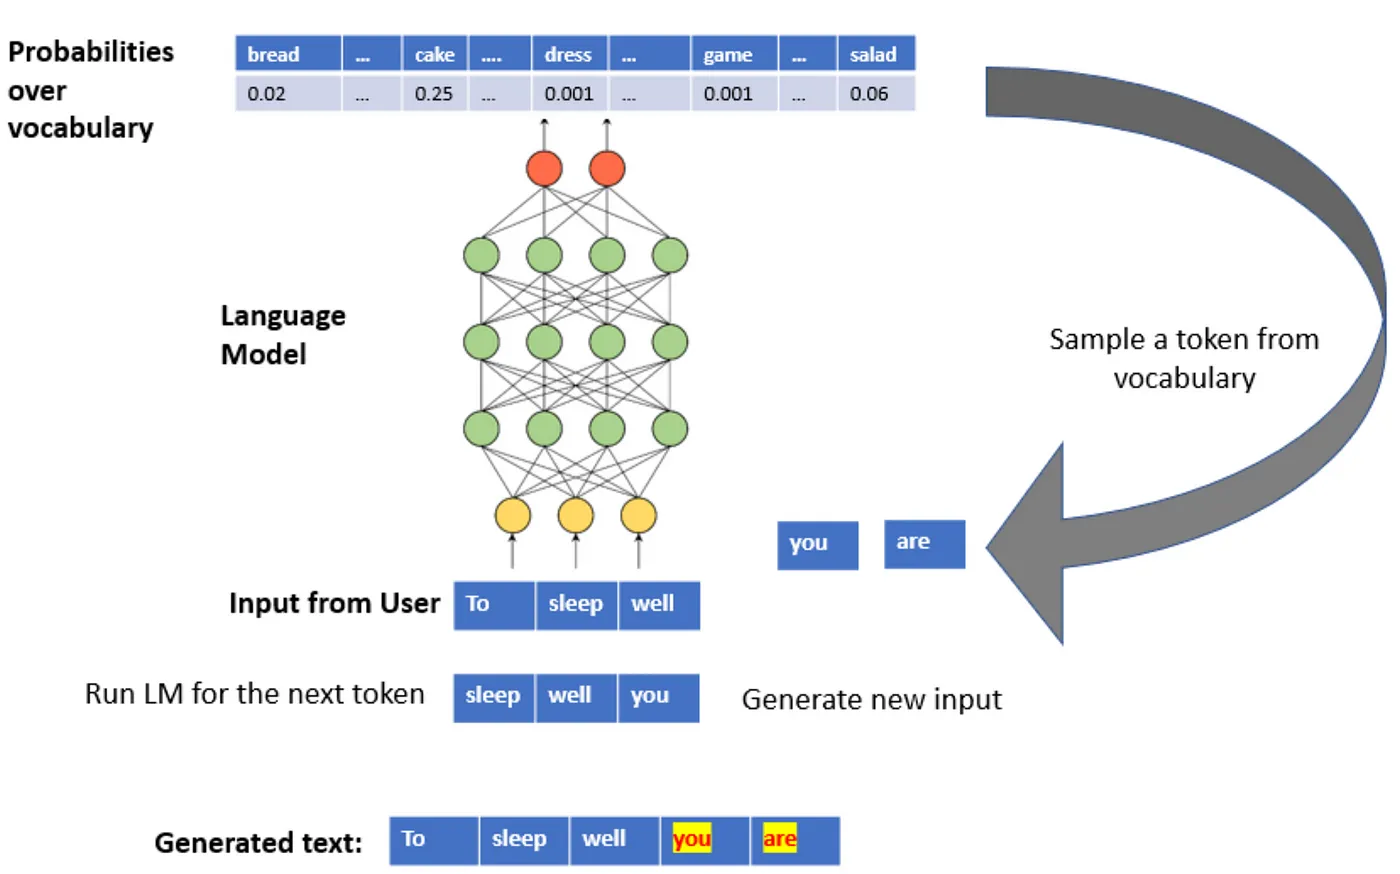

In [111]:
!pip install --quiet bs4
!pip install --quiet demoji

In [112]:
import torch
import pytorch_lightning as pl 
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import demoji
import numpy as np
import torch.nn as nn
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch.nn.functional as F
import torchtext
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from torch.utils.data import random_split
from torchtext.data.utils import get_tokenizer

In [113]:
medium_data = pd.read_csv('/kaggle/input/medium-articles-dataset/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [114]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [115]:
def remove_html_tags(title):
    soup = BeautifulSoup(title, 'html.parser')
    return soup.get_text()

In [116]:
def remove_non_alphabetic(title):
    return re.sub('[^a-zA-Z]', ' ', title)

In [117]:
def remove_imojis(title):
    return demoji.replace(title, '')

In [118]:
def preprocessing_title(title):
    title = remove_html_tags(title)
    title = remove_imojis(title)
    title = remove_non_alphabetic(title)
    title.replace(u'\xa0', u' ')
    title.replace('\x200a', ' ')
    return title

In [119]:
titles = medium_data['title'].apply(preprocessing_title)

/tmp/ipykernel_47/902917756.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(title, 'html.parser')


In [120]:
tokenizer = get_tokenizer('basic_english')

In [121]:
tokenized_titles = [tokenizer(title) for title in titles]

In [122]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_titles,
    min_freq=2,
    specials=['<pad>', '<oov>'],
    special_first=True
)

In [123]:
vocab_size = len(features_vocab)
print(vocab_size)

3571


In [124]:
print('<pad> -> '+ str(features_vocab['<pad>']))
print('<oov> -> '+ str(features_vocab['<oov>']))

<pad> -> 0
<oov> -> 1


In [125]:
titlr = "Hello, How are you"
tt = tokenizer(titlr) 
print(tt)
xx = [features_vocab[word] if word in features_vocab.get_itos() else features_vocab['<pad>'] for word in tt]
xx

['hello', ',', 'how', 'are', 'you']


[0, 0, 6, 29, 10]

In [126]:
input_sequences = []
for line in tokenized_titles:
    token_list = [features_vocab[word] if word in features_vocab.get_itos() else features_vocab['<pad>'] for word in line]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


In [127]:
print("Total input sequences: ", len(input_sequences))

Total input sequences:  44910


In [128]:
X = [lst[:-1] for lst in input_sequences]
Y = [lst[-1] for lst in input_sequences]

In [129]:
# find the max len of input feature , needed for padding
max_length = max(map(len, X))
print("max length of input seq",max_length)

max length of input seq 23


In [130]:
X = [[0] * (max_length - len(lst)) + lst for lst in X]

In [131]:
X = torch.tensor(X, dtype=torch.long)  
Y = torch.tensor(Y, dtype=torch.long)  

In [132]:
print(X.shape)
print(Y.shape)

torch.Size([44910, 23])
torch.Size([44910])


In [148]:
class BiLSTMModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(BiLSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embedding_dim,
                                      padding_idx=0)
        
        self.mha = nn.MultiheadAttention(embedding_dim, 
                                         num_heads = 2,
                                         batch_first=True,
                                         dropout=0.2)
        
        self.bilstm = nn.LSTM(embedding_dim, 
                              hidden_size, 
                              num_layers=1,
                              dropout=0.2,
                              batch_first=True, 
                              bidirectional=True)
        
        self.linear = nn.Sequential(
                nn.Dropout(0.2),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_size*2),
                nn.Linear(hidden_size*2, vocab_size),  # Multiply by 2 because of bidirectional LSTM
                nn.LogSoftmax(dim=1))
        

        self.criterion = nn.NLLLoss(ignore_index=0)
        self.val_accuracy = 0.0
        self.total_predictions = 0
        


    def forward(self, x):
        embedded = self.embedding(x)
        mha_out,mha_out_wghts = self.mha(embedded, embedded, embedded)
        lstm_out, _ = self.bilstm(mha_out)
        output = self.linear(lstm_out[:, -1, :])
        return output
    
    def training_step(self, batch, batch_idx) :
        x,label = batch
        output = self.forward(x)
        loss = self.criterion(output, label.argmax(dim=1))
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx) :
        x,label = batch
        output = self.forward(x)
        loss = self.criterion(output, label.argmax(dim=1))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        # Get top-k predictions
        _, predicted_indices = output.topk(k=3, dim=1)

        # Check if the correct label is in the top-k predictions
        self.val_accuracy += torch.any(predicted_indices == torch.argmax(label, dim=1, keepdim=True), dim=1).sum().item()
        self.total_predictions += label.size(0)
    
    def on_validation_epoch_end(self):
        accuracy = self.val_accuracy / self.total_predictions
        self.log('val_accuracy', accuracy)
        print(f" Accuracy: {accuracy * 100:.2f}%")

    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001)
        
    

In [149]:
# Define a custom dataset
class SequenceDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        ys = F.one_hot(self.target_sequences[idx], num_classes=vocab_size)

        return self.input_sequences[idx], ys


In [150]:
class SequenceDataModule(pl.LightningDataModule):
    def __init__(self, input_sequences, target_sequences, batch_size=32):
        super(SequenceDataModule, self).__init__()
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        # Split dataset into training and validation sets
        total_samples = len(self.input_sequences)
        val_samples = int(0.2 * total_samples)  # Adjust the validation split as needed
        train_samples = total_samples - val_samples

        self.train_dataset, self.val_dataset = random_split(
            dataset=SequenceDataset(self.input_sequences, self.target_sequences),
            lengths=[train_samples, val_samples],
            generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=3,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, num_workers=3,batch_size=self.batch_size)

In [151]:
epochs = 100
batch_size = 2048

In [152]:
# Instantiate your SequenceDataModule
data_module = SequenceDataModule(X, Y, batch_size=batch_size)

data_module.setup()

In [153]:
# Optionally, inspect the datasets and dataloaders
print("Train Dataset Length:", len(data_module.train_dataset))
print("Val Dataset Length:", len(data_module.val_dataset))

Train Dataset Length: 35928
Val Dataset Length: 8982


In [154]:
model = BiLSTMModel(vocab_size, embedding_dim=128, hidden_size=128)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [155]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'BestNWP',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [156]:
trainer = pl.Trainer(devices=-1, 
                  accelerator="gpu",
                  check_val_every_n_epoch=5,
                  callbacks=[checkpoint_callback],
                  max_epochs=epochs)

In [157]:
trainer.fit(model=model,datamodule=data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 0.07%


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 12.49%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 16.07%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 17.82%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 18.86%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 19.54%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.02%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.31%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.52%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.63%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.70%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.71%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.71%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.72%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.74%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.73%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.72%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.69%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.69%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.68%


Validation: |          | 0/? [00:00<?, ?it/s]

 Accuracy: 20.68%


In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [159]:
def predict(seed_text,next_words=3):
    
    print("Actual : ",seed_text)

    # Generate next words
    for _ in range(next_words):
        # Tokenize seed_text
        token_list = tokenizer(seed_text) 
        token_list = [features_vocab[word] if word in features_vocab.get_itos() else features_vocab['<oov>'] for word in token_list]   
        token_list = [0] * (max_length - len(token_list)) + token_list
        
        token_list = torch.tensor(token_list, dtype=torch.long).unsqueeze(0)  # Use torch.long if your data type is integer
                
        # Move token_list to GPU if available
        token_list = token_list #.to(device)
        model.eval()
        with torch.no_grad():
            output = model(token_list)
            
        # Get the index of the predicted word
        predicted_index = torch.argmax(output, dim=-1)
        
        # Convert index to word
        output_word = features_vocab.lookup_token(predicted_index.item())

        # Update the seed_text
        seed_text += " " + output_word
        
    print("Predict : ",seed_text)

In [167]:
medium_data.iloc[15]['title']

'How to Automate Hyperparameter Optimization'

In [164]:
seed_text = "How to Automate"

In [162]:
# Print the generated text
predict(seed_text,next_words=2)

Actual :  How to Automate
Predict :  How to Automate hyperparameter optimization


In [169]:
medium_data.iloc[17]['title']

'RoboSomm Chapter 3: Wine Embeddings and a Wine Recommender'

In [166]:
predict(seed_text='RoboSomm Chapter 3: Wine',next_words=5)

Actual :  RoboSomm Chapter 3: Wine
Predict :  RoboSomm Chapter 3: Wine embeddings and a wine recommender
